In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('/content/data-assignment2.csv')
index = pd.read_csv('/content/index-assignment2.csv')


In [ ]:
# Initialize an empty list to store combined data
combined_data = []

# Loop over each row in index_df
for _, row in index.iterrows():
    tweet_id = row['tweet_id']
    post_time_day = row['post_time_day']

    # Convert 'start_ind' and 'end_ind' to integers, handling NaNs
    start_ind = int(row['start_ind']) if pd.notna(row['start_ind']) else 0  # Replace NaN with 0 or another appropriate value
    end_ind = int(row['end_ind']) if pd.notna(row['end_ind']) else 0  # Replace NaN with 0 or another appropriate value

    # Ensure start_ind is less than or equal to end_ind
    if start_ind <= end_ind:
        # Slice the corresponding data from data_df using start and end indices
        sliced_data = data.iloc[start_ind:end_ind+1].copy()  # +1 to include the end_ind row

        # Add tweet_id and post_time_day to the sliced data
        sliced_data['tweet_id'] = tweet_id
        sliced_data['post_time_day'] = post_time_day

        # Append the combined data to the list
        combined_data.append(sliced_data)

# Concatenate all the sliced data into a single dataframe
df = pd.concat(combined_data, ignore_index=True)

df.head()

,relative_time_second,number_of_followers,tweet_id,post_time_day
0,84833.0,46828.0,1.224346e+17,0.926644
1,84878.0,208.0,1.224346e+17,0.926644
2,84883.0,37.0,1.224346e+17,0.926644
3,84900.0,137.0,1.224346e+17,0.926644
4,84904.0,254.0,1.224346e+17,0.926644


In [ ]:
df.to_csv('combined_data.csv', index=False)

In [ ]:
df=pd.read_csv('/content/combined_data.csv')

In [ ]:
df.columns

Index(['relative_time_second', 'number_of_followers', 'tweet_id',
       'post_time_day'],
      dtype='object')

In [ ]:
df['cascade_size'] = df.groupby('tweet_id')['tweet_id'].transform('count')

In [ ]:
features = ['relative_time_second', 'number_of_followers']
target = 'cascade_size'

In [ ]:
df.dropna(subset=features + [target], inplace=True)

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features].values)

In [ ]:
y = df[target].values

In [ ]:
# Reshape Data for LSTM with Attention
X = X.reshape((X.shape[0], 1, X.shape[1]))  # LSTM input shape: (samples, timesteps, features)

In [ ]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 4: Define the DeepHawkes Model with Attention Mechanism
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

In [ ]:
# LSTM layers
lstm_out = LSTM(64, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(32, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

In [ ]:
# Attention layer
attention_layer = Attention()([lstm_out, lstm_out])
concat_layer = Concatenate()([lstm_out, attention_layer])

In [ ]:
# Output layer
output_layer = Dense(1, activation='linear')(concat_layer)

In [ ]:
# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Step 5: Train the Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Fit the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16614/16620 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1788710.2500

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16620/16620 ━━━━━━━━━━━━━━━━━━━━ 110s 6ms/step - loss: 1788660.8750 - val_loss: 1519417.2500
Epoch 2/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/step - loss: 1522648.6250 - val_loss: 1511824.6250
Epoch 3/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - loss: 1511216.3750 - val_loss: 1511796.8750
Epoch 4/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 1536786.0000 - val_loss: 1511824.5000
Epoch 5/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 145s 6ms/step - loss: 1543272.2500 - val_loss: 1511913.5000
Epoch 6/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 139s 6ms/step - loss: 1520221.2500 - val_loss: 1511823.5000
Epoch 7/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 1534548.6250 - val_loss: 1511816.3750
Epoch 8/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - loss: 1535080.0000 - val_loss: 1511811.8750
Epoch 9/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 98s 6ms/step - loss: 1526048.0000 - val_loss: 1511814.1250
Epoch 10/20
16620/16620 ━━━━━━━━━━━━━━━━━━━━ 139s 6ms/step - loss: 1535327.37

In [ ]:
# Step 6: Evaluate the Model on Test Data
y_pred = model.predict(X_test)

5194/5194 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [ ]:
y_pred = y_pred.reshape(y_pred.shape[0], -1)  # Reshape to (number_of_samples, 1)

# Calculate Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1509693.831341431
Mean Absolute Error: 658.8058930214562


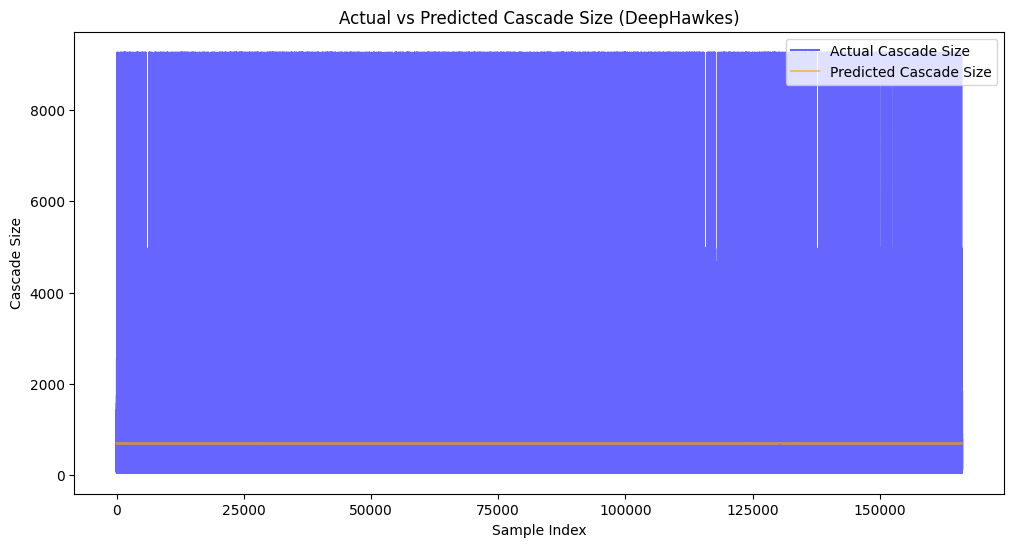

In [ ]:
# Step 7: Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cascade Size', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Cascade Size', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Cascade Size (DeepHawkes)')
plt.xlabel('Sample Index')
plt.ylabel('Cascade Size')
plt.legend()
plt.show()